In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import seaborn
import pandas as pd

Generate data

In [2]:
season = 2016
maxdelta = 3 #rounds larger values to this one

In [3]:
teams = []
games = []
times = []
diffs = []
for team in pm2.get_teams(season):
    gamescorediff = {}
    teamscore = 0
    oppscore = 0
    for line in pm2.read_team_pbp(team, season, types=['GOAL'], strengths=['all']):
        g = pm2.get_game(line)
        if g not in gamescorediff:
            gamescorediff[g] = {i: None for i in range(3900)}
            teamscore = 0
            oppscore = 0
        time = pm2.convert_time(pm2.get_event_time(line), pm2.get_event_period(line))
        if pm2.get_acting_team(line) == team:
            teamscore += 1
            olddiff = teamscore - oppscore - 1
        else:
            oppscore += 1
            olddiff = teamscore - oppscore + 1
        if time <= 3900:
            if olddiff > maxdelta:
                olddiff = maxdelta
            if olddiff < -1 * maxdelta:
                olddiff = -1 * maxdelta
            gamescorediff[g][time] = int(olddiff)
            
            for j in range(time - 1, -1, -1):
                if gamescorediff[g][j] is not None:
                    break
                else:
                    gamescorediff[g][j] = olddiff
                    
    teams += [team] * len(gamescorediff) * 3900
    for g in gamescorediff:
        games += [g] * 3900
        times += [i for i, v in gamescorediff[g].items()]
        diffs += [v for i, v in gamescorediff[g].items()]
    #print('Done with', team)
masterscoredct = {'Team': teams, 'Game': games, 'Time': times, 'ScoreDiff': diffs}
scoresdf = pd.DataFrame(masterscoredct)

In [4]:
teams = []
games = []
times = []
for team in pm2.get_teams(season):
    for line in pm2.read_team_toi(team, season):
        time = int(line[2])
        teams.append(team)
        games.append(pm2.get_game(line))
        times.append(time)
    #print('Done with', team)
timesdf = pd.DataFrame({'Team': teams, 'Game': games, 'Time': times})

In [5]:
df = timesdf.merge(scoresdf, how='left', on=['Game', 'Team', 'Time'])
df['ScoreDiff'].fillna(method='ffill', inplace=True)
df.head()

,Game,Team,Time,ScoreDiff
0,20005,MTL,1,0.0
1,20005,MTL,2,0.0
2,20005,MTL,3,0.0
3,20005,MTL,4,0.0
4,20005,MTL,5,0.0


In [6]:
grouped = df.groupby(['Team', 'ScoreDiff']).count()
grouped.reset_index(inplace=True)
pivoted = grouped.pivot(index = 'Team', columns = 'ScoreDiff', values = 'Time')
pivoted.head()

ScoreDiff,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0
Team,,,,,,,
ANA,9053,14383,31823,79803,36247,12043,7368
ARI,12675,21997,36776,70567,25745,13732,5293
BOS,4913,15428,29291,75537,32788,13118,14495
BUF,8578,18615,42907,65944,36812,16056,6511
CAR,8534,16429,30896,77959,38582,10728,3356


(0, 100)

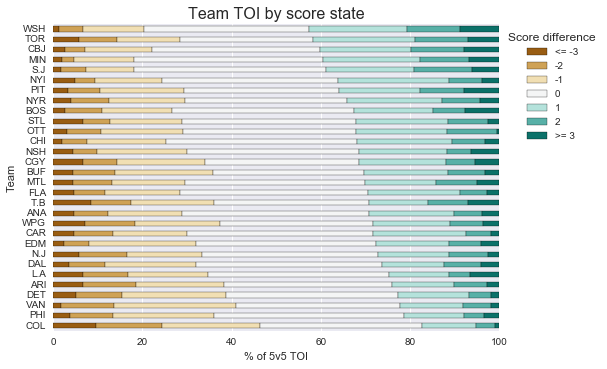

In [7]:
seaborn.set_palette(seaborn.color_palette("BrBG", 7), 7)
temp = pivoted.rename(columns = {x: str(int(x)) for x in pivoted.columns})

# Change to percentages
temp['TotTime'] = temp.sum(axis = 1)
for col in temp.columns:
    temp.loc[:, col] = temp[col]/temp['TotTime'] * 100
    
# Sort by most time leading
temp['LeadTime'] = temp['3'] + temp['2'] + temp['1']
temp.sort_values(by='LeadTime', inplace = True)
temp.drop({'LeadTime', 'TotTime'}, axis=1, inplace = True)

# Rename +3 and -3
temp = temp.rename(columns = {'-3': '<= -3', '3': '>= 3'})

temp.plot.barh(stacked = True)
legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Score difference')
title('Team TOI by score state', size = 16)
xlabel('% of 5v5 TOI')
xlim(0, 100)